<a href="https://colab.research.google.com/github/djdrjeff/phase1project/blob/main/phaseoneproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Necessary libraries**

In [ ]:
#import pandas library
import pandas as pd

#import the numpy library
import numpy as np

#import the matplotlib library
import matplotlib.pyplot as plt

#import the seaborn library
import seaborn as sns

**Read and Load Datasets from the provided CSV files**

In [ ]:

#load both files and read with the necessary encoding parameter
df = 'AviationData.csv'
aviation_data = pd.read_csv(df, encoding='ISO-8859-1')
us_state_codes = pd.read_csv('USState_Codes.csv')

<ipython-input-5-928588fe9c56>:3: DtypeWarning: Columns (6,7,28) have mixed types. Specify dtype option on import or set low_memory=False.
  aviation_data = pd.read_csv(df, encoding='ISO-8859-1')


In [ ]:
# Display the first few rows of each dataset to understand their structures
aviation_data.head(), us_state_codes.head()

(         Event.Id Investigation.Type Accident.Number  Event.Date  \
 0  20001218X45444           Accident      SEA87LA080  1948-10-24   
 1  20001218X45447           Accident      LAX94LA336  1962-07-19   
 2  20061025X01555           Accident      NYC07LA005  1974-08-30   
 3  20001218X45448           Accident      LAX96LA321  1977-06-19   
 4  20041105X01764           Accident      CHI79FA064  1979-08-02   
 
           Location        Country   Latitude  Longitude Airport.Code  \
 0  MOOSE CREEK, ID  United States        NaN        NaN          NaN   
 1   BRIDGEPORT, CA  United States        NaN        NaN          NaN   
 2    Saltville, VA  United States  36.922223 -81.878056          NaN   
 3       EUREKA, CA  United States        NaN        NaN          NaN   
 4       Canton, OH  United States        NaN        NaN          NaN   
 
   Airport.Name  ... Purpose.of.flight Air.carrier Total.Fatal.Injuries  \
 0          NaN  ...          Personal         NaN                  2

In [ ]:
#display the first five rows of the DataFrame named
us_state_codes.head()

,US_State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


**Data Cleaning**

In [ ]:
# Handling missing values
# Drop rows where there are missing values in critical columns for risk analysis
columns_to_check = ['Aircraft.damage', 'Make', 'Model', 'Total.Fatal.Injuries', 'Total.Serious.Injuries']
aviation_data.dropna(subset=columns_to_check, inplace=True)

In [ ]:
# Impute missing 'Number.of.Engines' with the mode
mode_engines = aviation_data['Number.of.Engines'].mode()[0]
aviation_data['Number.of.Engines'].fillna(mode_engines, inplace=True)

In [ ]:
# Convert 'Event.Date' to datetime format for easier manipulation
aviation_data['Event.Date'] = pd.to_datetime(aviation_data['Event.Date'])

In [ ]:
# Extract state abbreviations from the 'Location' field
aviation_data['State'] = aviation_data['Location'].str.extract(r', (\w\w)$')

In [ ]:
# Data integration: Merge with state codes to standardize state names
aviation_data = aviation_data.merge(us_state_codes, left_on='State', right_on='Abbreviation', how='left')

In [ ]:
# Replace state abbreviations with full state names for clarity in visualizations
aviation_data['State'] = aviation_data['US_State'].fillna(aviation_data['State'])

In [ ]:
# Drop unnecessary columns after the merge
aviation_data.drop(columns=['Abbreviation', 'US_State'], inplace=True)

In [ ]:
# Verify and view the cleaned data
print(aviation_data.head())

         Event.Id Investigation.Type Accident.Number Event.Date  \
0  20001218X45444           Accident      SEA87LA080 1948-10-24   
1  20001218X45447           Accident      LAX94LA336 1962-07-19   
2  20001218X45448           Accident      LAX96LA321 1977-06-19   
3  20041105X01764           Accident      CHI79FA064 1979-08-02   
4  20001218X45446           Accident      CHI81LA106 1981-08-01   

          Location        Country Latitude Longitude Airport.Code  \
0  MOOSE CREEK, ID  United States      NaN       NaN          NaN   
1   BRIDGEPORT, CA  United States      NaN       NaN          NaN   
2       EUREKA, CA  United States      NaN       NaN          NaN   
3       Canton, OH  United States      NaN       NaN          NaN   
4       COTTON, MN  United States      NaN       NaN          NaN   

  Airport.Name  ... Air.carrier Total.Fatal.Injuries Total.Serious.Injuries  \
0          NaN  ...         NaN                  2.0                    0.0   
1          NaN  ...     

# **EDA**

In [ ]:
# Check if 'State' column exists and create it if necessary
if 'State' not in aviation_data.columns:
    # Assuming 'Location' field contains state information in the form 'City, State'
    aviation_data['State'] = aviation_data['Location'].str.extract(r', (\w\w)$')

    # Merge with the US state codes to standardize state names
    aviation_data = aviation_data.merge(us_state_codes, left_on='State', right_on='Abbreviation', how='left')
    aviation_data['State'] = aviation_data['US_State'].fillna(aviation_data['State'])
    aviation_data.drop(columns=['Abbreviation', 'US_State'], inplace=True)

# Now, reattempt to aggregate data by Aircraft Model and State
model_state_summary = aviation_data.groupby(['Make', 'Model', 'State']).agg(
    Total_Accidents=('Event.Id', 'count'),
    Fatal_Accidents=('Total.Fatal.Injuries', lambda x: (x > 0).sum()),
    Serious_Accidents=('Total.Serious.Injuries', lambda x: (x > 0).sum())
).reset_index()




In [ ]:
# Filter out models with very few data points to ensure statistical significance
filtered_summary = model_state_summary[model_state_summary['Total_Accidents'] > 10]

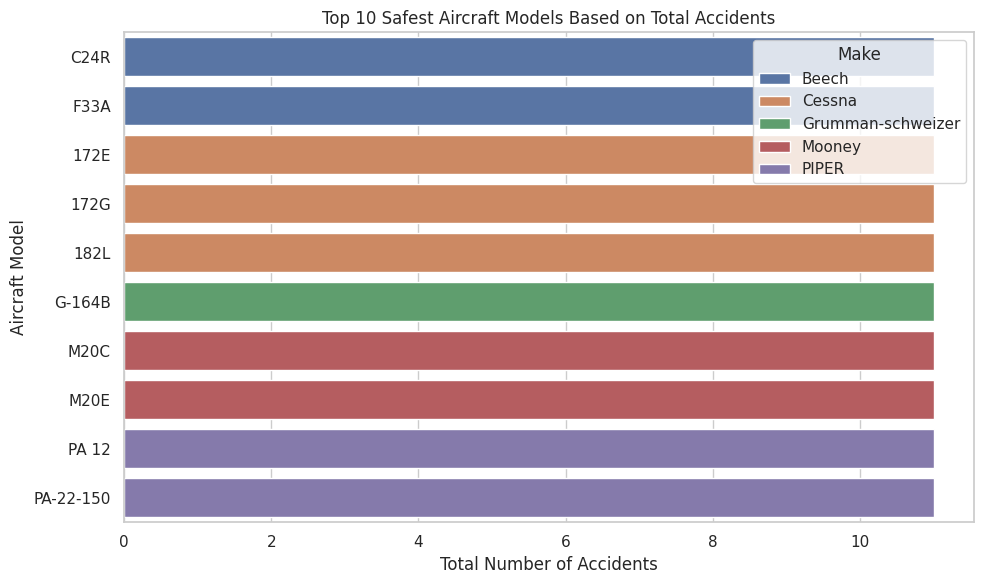

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up visualization style
sns.set(style="whitegrid")

# Aggregating data by Aircraft Model and State
model_state_summary = aviation_data.groupby(['Make', 'Model', 'State']).agg(
    Total_Accidents=('Event.Id', 'count'),
    Fatal_Accidents=('Total.Fatal.Injuries', lambda x: (x > 0).sum()),
    Serious_Accidents=('Total.Serious.Injuries', lambda x: (x > 0).sum())
).reset_index()

# Filter out models with very few data points to ensure statistical significance
filtered_summary = model_state_summary[model_state_summary['Total_Accidents'] > 10]

# Total Accidents by Aircraft Model - Top 10 safest models
safest_models = filtered_summary.groupby(['Make', 'Model']).Total_Accidents.sum().nsmallest(10).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=safest_models, x='Total_Accidents', y='Model', hue='Make', dodge=False)
plt.title('Top 10 Safest Aircraft Models Based on Total Accidents')
plt.xlabel('Total Number of Accidents')
plt.ylabel('Aircraft Model')
plt.legend(title='Make')
plt.tight_layout()

plt.show()

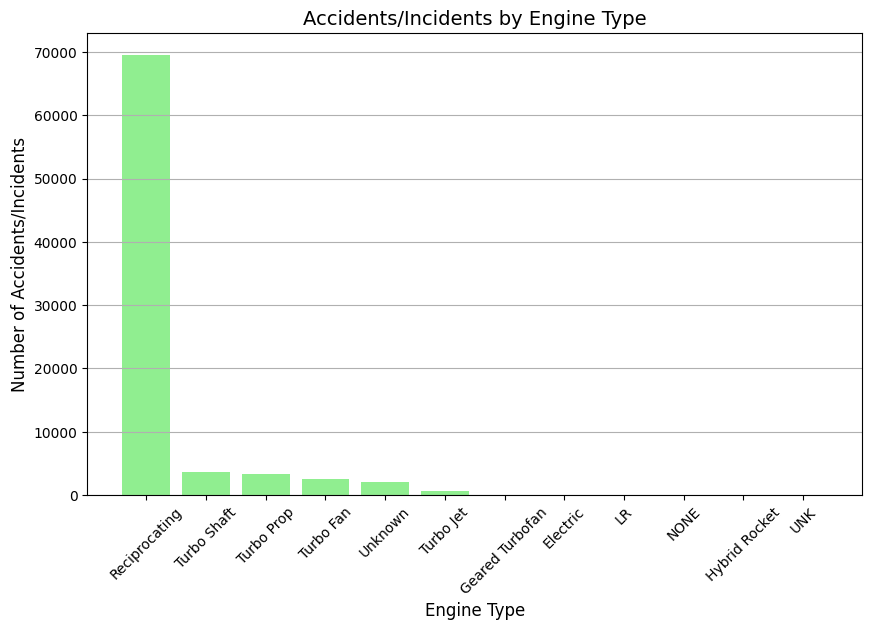

In [ ]:
# Group the data by 'Engine.Type' and calculate the count of accidents/incidents for each type
accidents_by_engine_type = aviation_data['Engine.Type'].value_counts().reset_index()
accidents_by_engine_type.columns = ['Engine Type', 'Accident Count']

# Plotting the accidents by engine type
plt.figure(figsize=(10, 6))
plt.bar(accidents_by_engine_type['Engine Type'], accidents_by_engine_type['Accident Count'], color='lightgreen')
plt.title('Accidents/Incidents by Engine Type', fontsize=14)
plt.xlabel('Engine Type', fontsize=12)
plt.ylabel('Number of Accidents/Incidents', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()


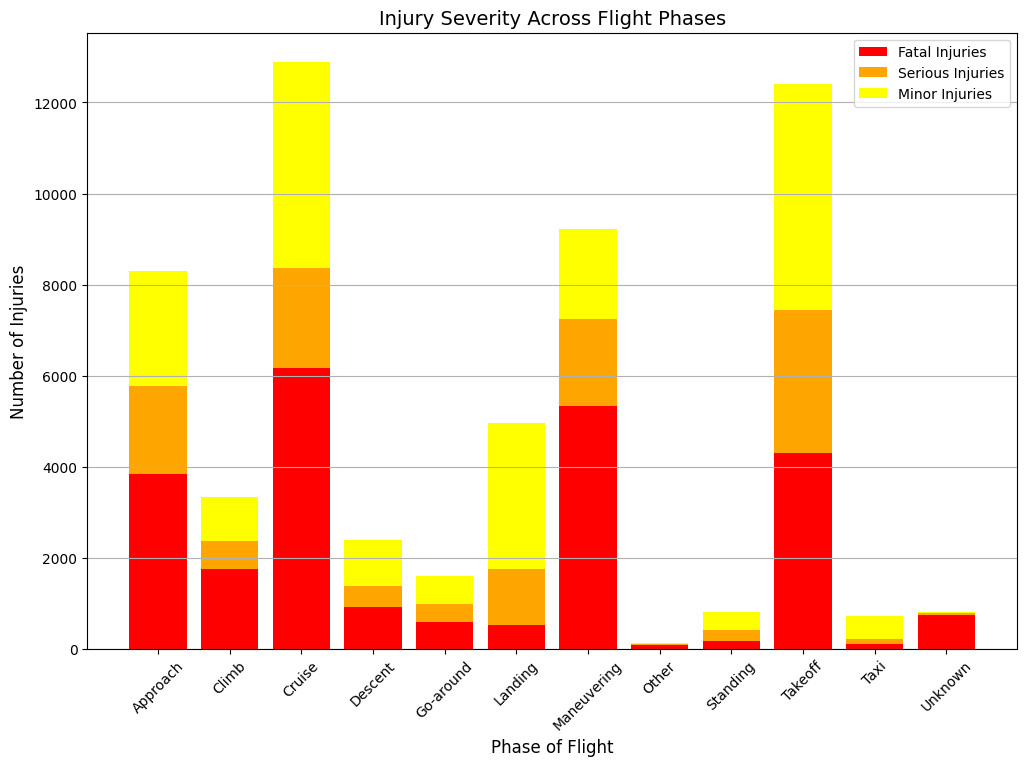

In [ ]:
# Group the data by 'Broad.phase.of.flight' and calculate the sum of injuries (Fatal, Serious, Minor) for each phase
injury_columns = ['Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries']
injury_severity_by_phase = aviation_data.groupby('Broad.phase.of.flight')[injury_columns].sum().reset_index()

# Plotting the injury severity across flight phases
plt.figure(figsize=(12, 8))

# Plot Fatal Injuries
plt.bar(injury_severity_by_phase['Broad.phase.of.flight'], injury_severity_by_phase['Total.Fatal.Injuries'],
        color='red', label='Fatal Injuries')

# Plot Serious Injuries on top of Fatal Injuries
plt.bar(injury_severity_by_phase['Broad.phase.of.flight'], injury_severity_by_phase['Total.Serious.Injuries'],
        bottom=injury_severity_by_phase['Total.Fatal.Injuries'], color='orange', label='Serious Injuries')

# Plot Minor Injuries on top of Fatal + Serious Injuries
plt.bar(injury_severity_by_phase['Broad.phase.of.flight'], injury_severity_by_phase['Total.Minor.Injuries'],
        bottom=injury_severity_by_phase['Total.Fatal.Injuries'] + injury_severity_by_phase['Total.Serious.Injuries'],
        color='yellow', label='Minor Injuries')

plt.title('Injury Severity Across Flight Phases', fontsize=14)
plt.xlabel('Phase of Flight', fontsize=12)
plt.ylabel('Number of Injuries', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, axis='y')
plt.show()


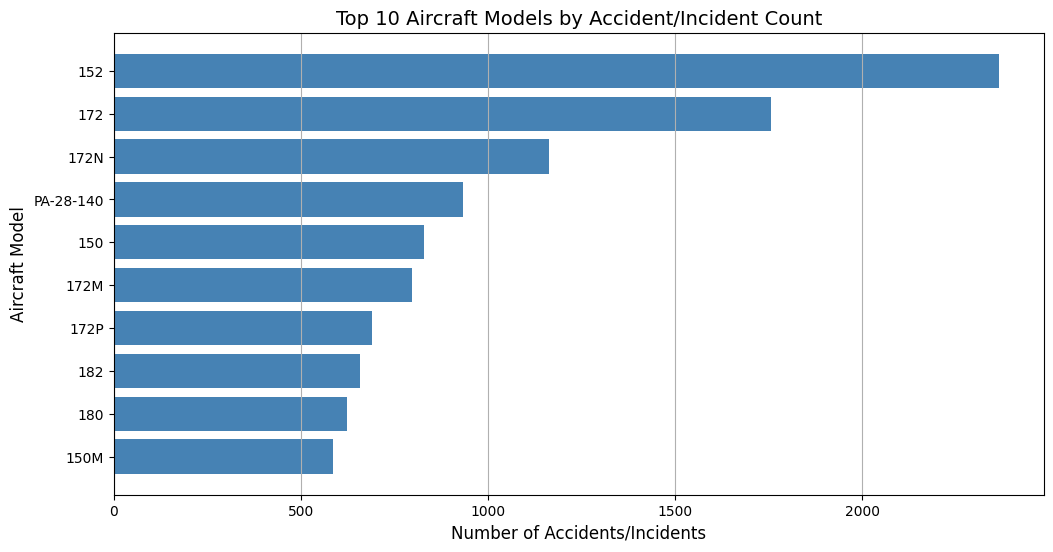

In [ ]:
# Group the data by 'Model' and calculate the count of accidents/incidents for each model
accidents_by_model = aviation_data['Model'].value_counts().reset_index()
accidents_by_model.columns = ['Model', 'Accident Count']

# Limit to top 10 models for visualization purposes
top_10_models = accidents_by_model.head(10)

# Plotting the top 10 aircraft models with the most accidents
plt.figure(figsize=(12, 6))
plt.barh(top_10_models['Model'], top_10_models['Accident Count'], color='steelblue')
plt.title('Top 10 Aircraft Models by Accident/Incident Count', fontsize=14)
plt.xlabel('Number of Accidents/Incidents', fontsize=12)
plt.ylabel('Aircraft Model', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.grid(True, axis='x')
plt.show()


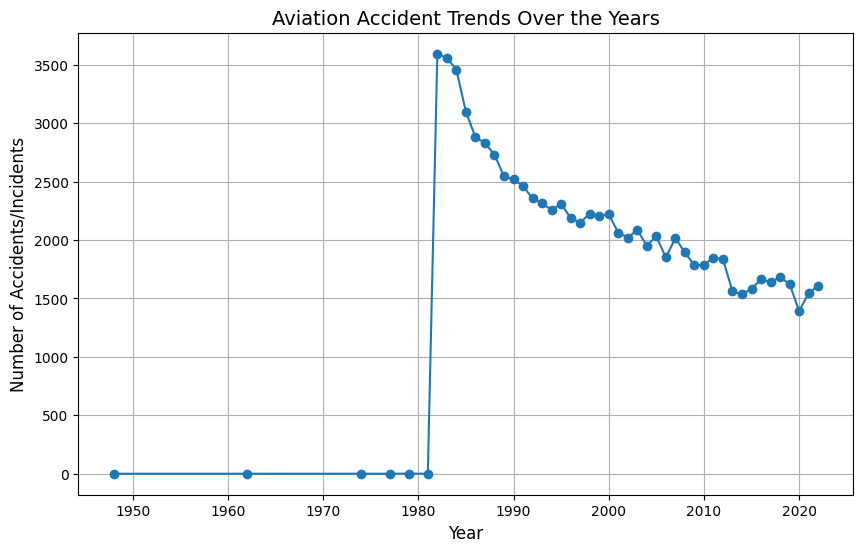

In [ ]:
# convert the 'Event.Date' column to a datetime format to extract the year for analysis

aviation_data['Event.Date'] = pd.to_datetime(aviation_data['Event.Date'], errors='coerce')

# Extract the year from the 'Event.Date' column
aviation_data['Year'] = aviation_data['Event.Date'].dt.year

# Group by the year and count the number of accidents/incidents per year
accident_trends = aviation_data.groupby('Year').size().reset_index(name='Accident Count')

# Plotting accident trends over the years
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(accident_trends['Year'], accident_trends['Accident Count'], marker='o', linestyle='-')
plt.title('Aviation Accident Trends Over the Years', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Accidents/Incidents', fontsize=12)
plt.grid(True)
plt.show()

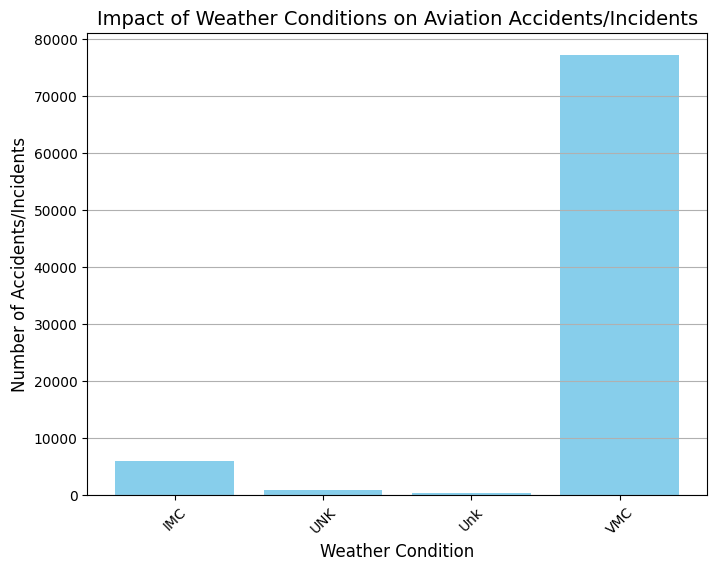

In [ ]:

# Group the data by 'Weather.Condition' and calculate the count of accidents/incidents for each category
weather_impact = aviation_data.groupby('Weather.Condition').size().reset_index(name='Accident Count')

# Plotting the impact of weather conditions on accidents/incidents
plt.figure(figsize=(8, 6))
plt.bar(weather_impact['Weather.Condition'], weather_impact['Accident Count'], color='skyblue')
plt.title('Impact of Weather Conditions on Aviation Accidents/Incidents', fontsize=14)
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Number of Accidents/Incidents', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

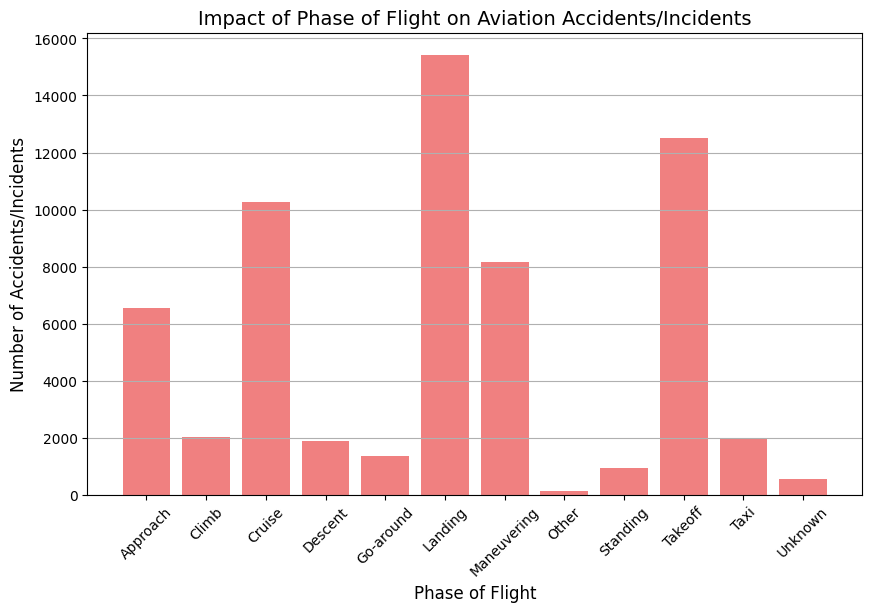

In [ ]:
# Group the data by 'Broad.phase.of.flight' and calculate the count of accidents/incidents for each phase
phase_of_flight_impact = aviation_data.groupby('Broad.phase.of.flight').size().reset_index(name='Accident Count')

# Plotting the impact of phase of flight on accidents/incidents
plt.figure(figsize=(10, 6))
plt.bar(phase_of_flight_impact['Broad.phase.of.flight'], phase_of_flight_impact['Accident Count'], color='lightcoral')
plt.title('Impact of Phase of Flight on Aviation Accidents/Incidents', fontsize=14)
plt.xlabel('Phase of Flight', fontsize=12)
plt.ylabel('Number of Accidents/Incidents', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

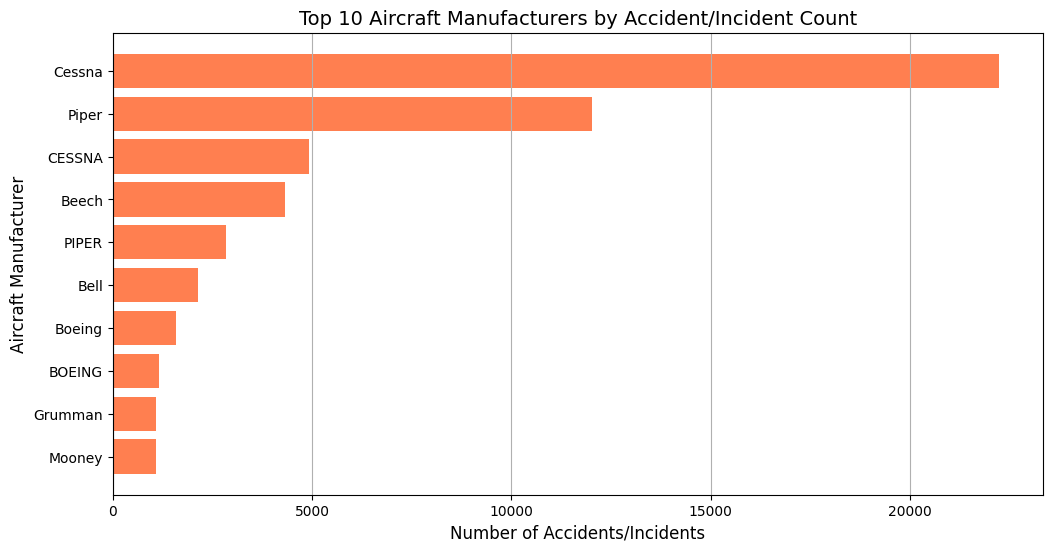

In [ ]:
# Group the data by 'Make' (manufacturer) and calculate the count of accidents/incidents for each manufacturer
accidents_by_manufacturer = aviation_data['Make'].value_counts().reset_index()
accidents_by_manufacturer.columns = ['Manufacturer', 'Accident Count']

# Limit to top 10 manufacturers for visualization purposes
top_10_manufacturers = accidents_by_manufacturer.head(10)

# Plotting the top 10 manufacturers with the most accidents
plt.figure(figsize=(12, 6))
plt.barh(top_10_manufacturers['Manufacturer'], top_10_manufacturers['Accident Count'], color='coral')
plt.title('Top 10 Aircraft Manufacturers by Accident/Incident Count', fontsize=14)
plt.xlabel('Number of Accidents/Incidents', fontsize=12)
plt.ylabel('Aircraft Manufacturer', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.grid(True, axis='x')
plt.show()


In [ ]:
#saving my cleaned data

cleaned_data = aviation_data
cleaned_data.to_csv('cleaned_data.csv', index=False)